In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 📌 Import all the required packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import imutils

# 📌 Set dataset path (update if needed)
dataset_path = "/content/drive/MyDrive/APS360 Building Recognition/filtered_images"

# 📌 Countries in dataset (folder names)
countries = ["France", "Greece", "Italy", "Japan", "Mexico"]

# 📌 KNN parameters
k_values = range(1, 11)  # k from 1 to 10
n_jobs = -1  # use all CPU cores


In [3]:
# 📌 Convert image to raw pixel features
def image_to_feature_vector(image, size=(32, 32)):
    return cv2.resize(image, size).flatten()

# 📌 Extract HSV color histogram
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    else:
        cv2.normalize(hist, hist)
    return hist.flatten()

# 📌 Extract SIFT descriptors
def extract_sift_features(image, vector_size=32):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create()
        kps, des = sift.detectAndCompute(gray, None)
        if des is None:
            return np.zeros(vector_size * 128)
        kps = sorted(kps, key=lambda x: -x.response)
        des = des[:vector_size]
        if des.shape[0] < vector_size:
            padding = np.zeros((vector_size - des.shape[0], 128))
            des = np.vstack((des, padding))
        return des.flatten()
    except cv2.error:
        return np.zeros(vector_size * 128)


In [ ]:
# 📌 Storage lists
rawImages, features, siftFeatures, combinedFeatures, labels = [], [], [], [], []

print("[INFO] Loading and describing images...")

imagePaths = list(paths.list_images(dataset_path))

for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    label = os.path.basename(os.path.dirname(imagePath))  # Country folder name

    # Extract features
    pixels = image_to_feature_vector(image)
    hist = extract_color_histogram(image)
    sift = extract_sift_features(image)
    combined = np.hstack([hist, sift])

    # Append to storage
    rawImages.append(pixels)
    features.append(hist)
    siftFeatures.append(sift)
    combinedFeatures.append(combined)
    labels.append(label)

    if (i + 1) % 500 == 0:
        print(f"[INFO] Processed {i+1}/{len(imagePaths)} images")

# Convert to NumPy arrays
rawImages = np.array(rawImages)
features = np.array(features)
siftFeatures = np.array(siftFeatures)
combinedFeatures = np.array(combinedFeatures)
labels = np.array(labels)

print("[INFO] Dataset shapes:")
print(f"Raw Pixels: {rawImages.shape}")
print(f"Color Hist: {features.shape}")
print(f"SIFT: {siftFeatures.shape}")
print(f"Combined: {combinedFeatures.shape}")


[INFO] Loading and describing images...
[INFO] Processed 500/3266 images
[INFO] Processed 1000/3266 images
[INFO] Processed 1500/3266 images
[INFO] Processed 2000/3266 images
[INFO] Processed 2500/3266 images
[INFO] Processed 3000/3266 images
[INFO] Dataset shapes:
Raw Pixels: (3266, 3072)
Color Hist: (3266, 512)
SIFT: (3266, 4096)
Combined: (3266, 4608)


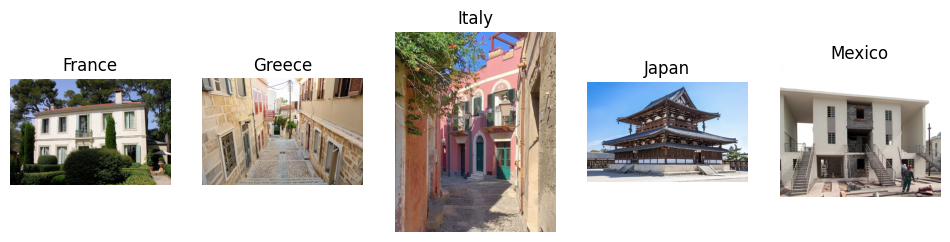

In [ ]:
import random

# 📌 Show one sample from each country
plt.figure(figsize=(12, 6))
for idx, country in enumerate(countries):
    country_images = [p for p in imagePaths if f"/{country}/" in p]
    sample_path = random.choice(country_images)
    img = cv2.imread(sample_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(countries), idx+1)
    plt.imshow(img)
    plt.title(country)
    plt.axis("off")
plt.show()


In [ ]:
# 📌 Split data into train/test (same split for all feature sets)
(trainRI, testRI, trainRL, testRL) = train_test_split(rawImages, labels, test_size=0.25, random_state=42)
(trainHist, testHist, trainHistLabels, testHistLabels) = train_test_split(features, labels, test_size=0.25, random_state=42)
(trainSIFT, testSIFT, trainSIFTLabels, testSIFTLabels) = train_test_split(siftFeatures, labels, test_size=0.25, random_state=42)
(trainCombo, testCombo, trainComboLabels, testComboLabels) = train_test_split(combinedFeatures, labels, test_size=0.25, random_state=42)


In [ ]:
def evaluate_knn_models(name, trainX, testX, trainY, testY):
    results = []
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k, n_jobs=n_jobs)
        model.fit(trainX, trainY)
        acc = model.score(testX, testY)
        results.append(acc * 100)
        print(f"{name} | k={k}: {acc*100:.2f}%")
    return results


In [ ]:
print("\n[INFO] Running models on NON-preprocessed data...\n")

acc_raw = evaluate_knn_models("Raw Pixels", trainRI, testRI, trainRL, testRL)
acc_hist = evaluate_knn_models("Color Histogram", trainHist, testHist, trainHistLabels, testHistLabels)
acc_sift = evaluate_knn_models("SIFT", trainSIFT, testSIFT, trainSIFTLabels, testSIFTLabels)
acc_combo = evaluate_knn_models("Color Histogram + SIFT", trainCombo, testCombo, trainComboLabels, testComboLabels)



[INFO] Running models on NON-preprocessed data...

Raw Pixels | k=1: 66.34%
Raw Pixels | k=2: 54.35%
Raw Pixels | k=3: 47.61%
Raw Pixels | k=4: 44.68%
Raw Pixels | k=5: 43.08%
Raw Pixels | k=6: 42.11%
Raw Pixels | k=7: 39.66%
Raw Pixels | k=8: 40.02%
Raw Pixels | k=9: 41.74%
Raw Pixels | k=10: 41.74%
Color Histogram | k=1: 67.69%
Color Histogram | k=2: 50.18%
Color Histogram | k=3: 45.90%
Color Histogram | k=4: 43.82%
Color Histogram | k=5: 44.43%
Color Histogram | k=6: 43.82%
Color Histogram | k=7: 43.45%
Color Histogram | k=8: 43.70%
Color Histogram | k=9: 43.45%
Color Histogram | k=10: 43.45%
SIFT | k=1: 58.75%
SIFT | k=2: 43.94%
SIFT | k=3: 39.66%
SIFT | k=4: 36.11%
SIFT | k=5: 35.37%
SIFT | k=6: 35.50%
SIFT | k=7: 34.52%
SIFT | k=8: 32.07%
SIFT | k=9: 32.44%
SIFT | k=10: 32.07%
Color Histogram + SIFT | k=1: 58.75%
Color Histogram + SIFT | k=2: 43.94%
Color Histogram + SIFT | k=3: 39.66%
Color Histogram + SIFT | k=4: 36.11%
Color Histogram + SIFT | k=5: 35.37%
Color Histogram + SI

In [ ]:
# 📌 Scale data
scaler_raw = StandardScaler().fit(trainRI)
scaler_hist = StandardScaler().fit(trainHist)
scaler_sift = StandardScaler().fit(trainSIFT)
scaler_combo = StandardScaler().fit(trainCombo)

trainRI_norm = scaler_raw.transform(trainRI)
testRI_norm = scaler_raw.transform(testRI)
trainHist_norm = scaler_hist.transform(trainHist)
testHist_norm = scaler_hist.transform(testHist)
trainSIFT_norm = scaler_sift.transform(trainSIFT)
testSIFT_norm = scaler_sift.transform(testSIFT)
trainCombo_norm = scaler_combo.transform(trainCombo)
testCombo_norm = scaler_combo.transform(testCombo)

print("\n[INFO] Running models on PREprocessed (scaled) data...\n")

acc_raw_scaled = evaluate_knn_models("Raw Pixels (Scaled)", trainRI_norm, testRI_norm, trainRL, testRL)
acc_hist_scaled = evaluate_knn_models("Color Histogram (Scaled)", trainHist_norm, testHist_norm, trainHistLabels, testHistLabels)
acc_sift_scaled = evaluate_knn_models("SIFT (Scaled)", trainSIFT_norm, testSIFT_norm, trainSIFTLabels, testSIFTLabels)
acc_combo_scaled = evaluate_knn_models("Color Histogram + SIFT (Scaled)", trainCombo_norm, testCombo_norm, trainComboLabels, testComboLabels)



[INFO] Running models on PREprocessed (scaled) data...

Raw Pixels (Scaled) | k=1: 66.95%
Raw Pixels (Scaled) | k=2: 54.96%
Raw Pixels (Scaled) | k=3: 48.59%
Raw Pixels (Scaled) | k=4: 44.80%
Raw Pixels (Scaled) | k=5: 41.98%
Raw Pixels (Scaled) | k=6: 41.13%
Raw Pixels (Scaled) | k=7: 40.02%
Raw Pixels (Scaled) | k=8: 39.53%
Raw Pixels (Scaled) | k=9: 40.64%
Raw Pixels (Scaled) | k=10: 42.11%
Color Histogram (Scaled) | k=1: 68.30%
Color Histogram (Scaled) | k=2: 51.77%
Color Histogram (Scaled) | k=3: 49.57%
Color Histogram (Scaled) | k=4: 46.14%
Color Histogram (Scaled) | k=5: 44.06%
Color Histogram (Scaled) | k=6: 44.06%
Color Histogram (Scaled) | k=7: 44.80%
Color Histogram (Scaled) | k=8: 45.53%
Color Histogram (Scaled) | k=9: 43.70%
Color Histogram (Scaled) | k=10: 44.19%
SIFT (Scaled) | k=1: 56.92%
SIFT (Scaled) | k=2: 41.62%
SIFT (Scaled) | k=3: 43.45%
SIFT (Scaled) | k=4: 44.06%
SIFT (Scaled) | k=5: 41.37%
SIFT (Scaled) | k=6: 37.09%
SIFT (Scaled) | k=7: 34.39%
SIFT (Scaled) |

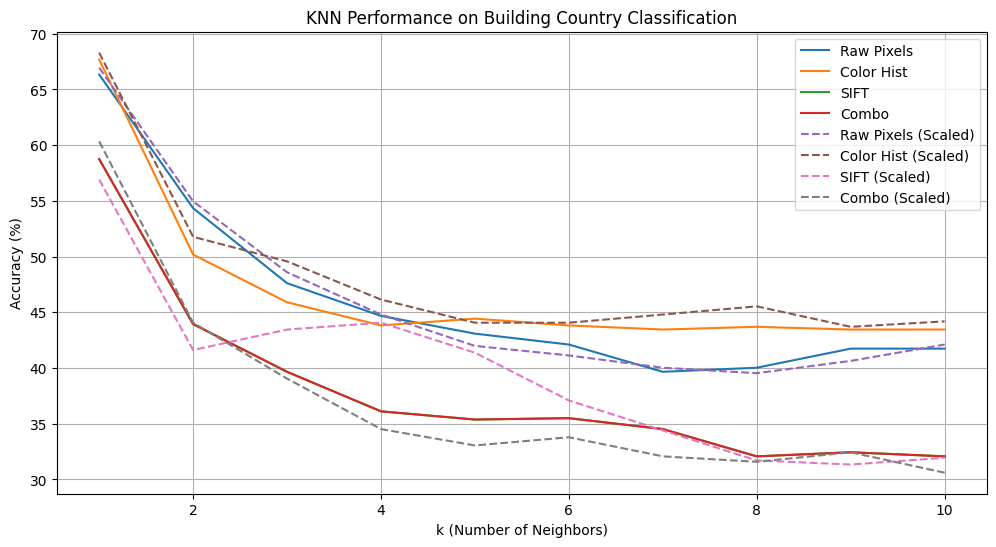

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(k_values, acc_raw, label="Raw Pixels")
plt.plot(k_values, acc_hist, label="Color Hist")
plt.plot(k_values, acc_sift, label="SIFT")
plt.plot(k_values, acc_combo, label="Combo")
plt.plot(k_values, acc_raw_scaled, '--', label="Raw Pixels (Scaled)")
plt.plot(k_values, acc_hist_scaled, '--', label="Color Hist (Scaled)")
plt.plot(k_values, acc_sift_scaled, '--', label="SIFT (Scaled)")
plt.plot(k_values, acc_combo_scaled, '--', label="Combo (Scaled)")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy (%)")
plt.title("KNN Performance on Building Country Classification")
plt.legend()
plt.grid(True)
plt.show()
